### mean Intersection over Union metric

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import glob
import csv

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

from wad_config import WadConfig
from wad_dataset import WadDataset
from wad_dataset_val import WadDatasetVal

print("Making config")
config = WadConfig()
inference_config=config
print("Creating Inference Model")
model = modellib.MaskRCNN(mode="inference",config=inference_config, model_dir=MODEL_DIR)

print(MODEL_DIR)

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Making config
Creating Inference Model
/home/stevenzc/Mask_RCNN/mrcnn/logs


In [2]:
# assumes that the weights are in the mrcnn/logs folder

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = model.find_last()[1]
print(model_path)

# NOTE: override with a specific path here
# model_path = '/home/stevenzc/Mask_RCNN/mrcnn/logs/wad20180517T2126/mask_rcnn_wad_0100.h5'

print("Loading weights")
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

/home/stevenzc/Mask_RCNN/mrcnn/logs/wad20180601T0805/mask_rcnn_wad_0452.h5
Loading weights
Loading weights from  /home/stevenzc/Mask_RCNN/mrcnn/logs/wad20180601T0805/mask_rcnn_wad_0452.h5


In [2]:
# Our WAD Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'car', 'motorcycle', 'bicycle', 'person', 'truck', 'bus', 'tricycle']

print('car', class_names.index('car'))
print('motorcycle', class_names.index('motorcycle'))
print('bicycle', class_names.index('bicycle'))
print('person', class_names.index('person'))
print('truck', class_names.index('truck'))
print('bus', class_names.index('bus'))
print('tricycle', class_names.index('tricycle'))

car 1
motorcycle 2
bicycle 3
person 4
truck 5
bus 6
tricycle 7


In [3]:
def get_mask(label_im):
    """Return single mask from training labels for iou checking."""
    instances = np.unique(label_im)

    wad_to_ours = {
        33: 1,
        34: 2,
        35: 3,
        36: 4,
        38: 5,
        39: 6,
        40: 7
    }
    
    mask = np.zeros_like(label_im)

    for instance in instances:
        if instance != 255 and instance != 65535:
            wad_id = int(instance / 1000)
            if wad_id not in wad_to_ours:
                continue
            our_id = wad_to_ours[wad_id]
            mask[label_im == instance] = our_id
    return mask

### Read the train video list and get the appropriate images and ground truth masks

In [4]:
video = 'road03_cam_6_video_17'

DVS_folder = '/home/stevenzc/train/' + video + '/'
video_list = '/home/stevenzc/cvpr-2018-autonomous-driving/train_video_list/' + video + '_image_list_train.txt'

In [5]:
WAD_TRAIN = "/home/stevenzc/cvpr-2018-autonomous-driving/train_color/"
WAD_TRAIN_MASK = "/home/stevenzc/cvpr-2018-autonomous-driving/train_label/"

with open(video_list) as f:
    content = f.readlines()
content = [x.strip() for x in content] 

train_image_paths = []
train_mask_image_paths = []

for line in content:
    raw_image_name = line.split('\\')[-1]
    # prefix looks like 171206_033003934_Camera_6
    prefix = raw_image_name.split('_instanceIds.png')[0]
    train_image_paths.append(WAD_TRAIN + prefix + '.jpg')
    train_mask_image_paths.append(WAD_TRAIN_MASK + prefix + '_instanceIds.png')

In [6]:
len(train_image_paths)

1137

In [27]:
instances = np.zeros(7)

wad_to_ours = {
        33: 1,
        34: 2,
        35: 3,
        36: 4,
        38: 5,
        39: 6,
        40: 7
    }

for i in range(len(train_image_paths)):
    if i % 10 == 0:
        print(i)
    img = skimage.io.imread(train_mask_image_paths[i])
    uniques = np.unique(img)
    for unique in uniques:
        if unique != 255 and unique != 65535:
            wad_id = int(unique / 1000)
            if wad_id not in wad_to_ours:
                continue
            our_id = wad_to_ours[wad_id]
            instances[our_id - 1] += 1

print(instances)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
[875.   2.   0.  15. 503.   0.   0.]


### Convert DVSNet masks into our format

In [40]:
label_colours = [(128, 64, 128), (244, 35, 231), (69, 69, 69)
                # 0 = road, 1 = sidewalk, 2 = building
                ,(102, 102, 156), (190, 153, 153), (153, 153, 153)
                # 3 = wall, 4 = fence, 5 = pole
                ,(250, 170, 29), (219, 219, 0), (106, 142, 35)
                # 6 = traffic light, 7 = traffic sign, 8 = vegetation
                ,(152, 250, 152), (69, 129, 180), (219, 19, 60)
                # 9 = terrain, 10 = sky, 11 = person
                ,(255, 0, 0), (0, 0, 142), (0, 0, 69)
                # 12 = rider, 13 = car, 14 = truck
                ,(0, 60, 100), (0, 79, 100), (0, 0, 230)
                # 15 = bus, 16 = train, 17 = motocycle
                ,(119, 10, 32)]
                # 18 = bicycle

dvs_to_ours = {
    13: 1,    # car 1
    17: 2,    # motorcycle 2
    18: 3,    # bicycle 3
    11: 4,    # person 4
    14: 5,    # truck 5
    15: 6,    # bus 6
              # tricycle 7
}

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


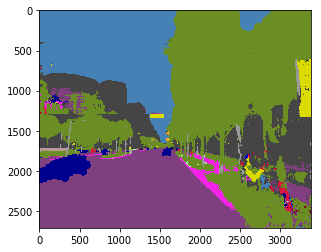

In [42]:
from scipy.misc import imresize

DVS_sample = DVS_folder + 'mask500.png'
img = skimage.io.imread(DVS_sample)
resized = imresize(img, (2710, 3384), interp='nearest')
plt.imshow(resized)

In [43]:
def dvs_mask_convert(dvs_mask):
    """Convert a DVS color mask into a WAD integer mask with our indices."""
    H, W, _ = dvs_mask.shape
    out_mask = np.zeros((H, W))
    for i, color in enumerate(label_colours):
        if i in dvs_to_ours:
            out_mask[(dvs_mask[:, :, 0] == color[0]) & 
                     (dvs_mask[:, :, 1] == color[1]) & 
                     (dvs_mask[:, :, 2] == color[2])] = dvs_to_ours[i]
    return out_mask

### mIoU for DVS masks

In [7]:
def iou(mask1, mask2):
    """Return array of iou values for each class.
    
    Each mask image expected to have int values [0, 7].
    
    Returns numpy array with 7 entries, each representing the class iou.
    
    If a class does not have any occurrences in mask1, then report iou of -1 as indicator."""
    iou_scores = np.zeros(7)
    for i in range(7):
        mask_val = i + 1
        intersection = np.count_nonzero((mask1 == mask_val) & (mask2 == mask_val))
        union = np.count_nonzero((mask1 == mask_val) | (mask2 == mask_val))
        if np.count_nonzero(mask1 == mask_val) == 0:
            iou_scores[i] = -1
        elif intersection == 0 or union == 0:
            continue
        else:
            iou_scores[i] = intersection / union
    return iou_scores

In [45]:
iou_scores = np.zeros(7)
counts = np.zeros(7)

for i in range(len(train_mask_image_paths)):
    if i % 10 == 0:
        print(i)
    
    # read in DVS mask
    DVS_path = DVS_folder + 'mask' + str(i) + '.png'
    DVS_img = skimage.io.imread(DVS_path)
    DVS_img = imresize(DVS_img, (2710, 3384), interp='nearest')
    DVS_mask = dvs_mask_convert(DVS_img)
    
    # read in training label mask
    train_mask_img = skimage.io.imread(train_mask_image_paths[i])
    train_mask = get_mask(train_mask_img)
    
    this_iou = iou(train_mask, DVS_mask)
    for index in range(7):
        if this_iou[index] >= 0.0:
            iou_scores[index] += this_iou[index]
            counts[index] += 1
print(iou_scores)
print(counts)

0


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
[4.02562326e+02 4.69889526e+01 1.17906930e+01 7.23898020e+01
 5.66939720e-03 0.00000000e+00 0.00000000e+00]
[1014.  415.  343.  736.  131.   17.   74.]


### mIoU for Mask R-CNN masks

In [ ]:
# visualize things (uncomment to run)

# mask_temp = skimage.io.imread(train_mask_image_paths[18])
# train_mask = get_mask(mask_temp)
# plt.imshow(train_mask, cmap='gray')

# image = skimage.io.imread(train_image_paths[18])
# results = model.detect([image], verbose=1)
# r = results[0]
# class_ids = r['class_ids']
# scores = r['scores']
# masks = r['masks']

# mrcnn_mask = np.zeros((2710, 3384))
# for i in range(len(class_ids)):
#     mrcnn_mask[masks[:, :, i]] = class_ids[i]
# plt.imshow(mrcnn_mask, cmap='gray')

# DVS_path = DVS_folder + 'mask' + '18' + '.png'
# DVS_img = skimage.io.imread(DVS_path)
# DVS_img = imresize(DVS_img, (2710, 3384), interp='nearest')
# DVS_mask = dvs_mask_convert(DVS_img)
# plt.imshow(DVS_mask, cmap='gray')

# print(iou(train_mask, mrcnn_mask))

In [8]:
# save all the mask r-cnn masks to make things faster later
video_len = len(train_mask_image_paths)
all_masks = np.zeros((video_len, 2710, 3384))

for i in range(video_len):
    if i % 10 == 0:
        print(i)
    img = skimage.io.imread(train_image_paths[i])
    results = model.detect([img], verbose=0)
    r = results[0]
    class_ids = r['class_ids']
    scores = r['scores']
    masks = r['masks']

    mrcnn_mask = np.zeros((2710, 3384))
    for x in range(len(class_ids)):
        mrcnn_mask[masks[:, :, x]] = class_ids[x]
    all_masks[i] = mrcnn_mask

MemoryError: 

In [11]:
iou_scores = np.zeros(7)
counts = np.zeros(7)

for i in range(len(train_mask_image_paths)):
    if i % 10 == 0:
        print(i)
    
    # read in training label mask
    train_mask_img = skimage.io.imread(train_mask_image_paths[i])
    train_mask = get_mask(train_mask_img)
    
    img = skimage.io.imread(train_image_paths[i])
    results = model.detect([img], verbose=0)
    r = results[0]
    class_ids = r['class_ids']
    scores = r['scores']
    masks = r['masks']

    mrcnn_mask = np.zeros((2710, 3384))
    for x in range(len(class_ids)):
        mrcnn_mask[masks[:, :, x]] = class_ids[x]
    
    this_iou = iou(train_mask, mrcnn_mask)
    
    for index in range(7):
        if this_iou[index] >= 0.0:
            iou_scores[index] += this_iou[index]
            counts[index] += 1
            
print(iou_scores)
print(counts)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
[674.10018017 143.22030919  65.0218264  205.95619625  25.06607482
   0.          15.52435592]
[1014.  415.  343.  736.  131.   17.   74.]


In [12]:
iou_scores / counts

array([0.66479308, 0.34510918, 0.18956801, 0.27983179, 0.19134408,
       0.        , 0.20978859])

### Mask R-CNN interpolation

In [21]:
iou_scores = np.zeros(7)
counts = np.zeros(7)

prev = np.zeros((2710, 3384))
curr = np.zeros((2710, 3384))
after = np.zeros((2710, 3384))


# load the first two frames
# img = skimage.io.imread(train_image_paths[i])
# results = model.detect([img], verbose=0)
# r = results[0]
# class_ids = r['class_ids']
# scores = r['scores']
# masks = r['masks']
# for x in range(len(class_ids)):
#     prev[masks[:, :, x]] = class_ids[x]

# img = skimage.io.imread(train_image_paths[i])
# results = model.detect([img], verbose=0)
# r = results[0]
# class_ids = r['class_ids']
# scores = r['scores']
# masks = r['masks']
# for x in range(len(class_ids)):
#     curr[masks[:, :, x]] = class_ids[x] 

# only use frames that have surrounding information
for i in range(1, len(train_mask_image_paths) - 1):
    if i % 10 == 1:
        print(i)
    
    # load in the after mask (index i + 1)
#     img = skimage.io.imread(train_image_paths[i + 1])
#     results = model.detect([img], verbose=0)
#     r = results[0]
#     class_ids = r['class_ids']
#     scores = r['scores']
#     masks = r['masks']

    prev = all_masks[i - 1]
    curr = all_masks[i]
    after = all_masks[i + 1]

#     after = np.zeros((2710, 3384))
#     for x in range(len(class_ids)):
#         after[masks[:, :, x]] = class_ids[x]
    
    # read in training label mask
    train_mask_img = skimage.io.imread(train_mask_image_paths[i])
    train_mask = get_mask(train_mask_img)
    
    # perform interpolation on a new mask using prev, curr, after
    mrcnn_mask = np.copy(curr)
    for index in range(7):
        mrcnn_mask[(prev == index) & (curr == 0) & (after == index)] = index
        mrcnn_mask[(prev == 0) & (curr != 0) & (after == 0)] = 0
    
    this_iou = iou(train_mask, mrcnn_mask)
    
    for index in range(7):
        if this_iou[index] >= 0.0:
            iou_scores[index] += this_iou[index]
            counts[index] += 1
    
    # move variables
#     prev = np.copy(curr)
#     curr = np.copy(after)

print(iou_scores)
print(counts)

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
[159.15981955   0.           0.           0.         213.36390482
   0.           0.        ]
[244.   2.   0.  13. 245.   0.   0.]


## Mask R-CNN COCO Pretrained

In [8]:
sys.path.append("/home/stevenzc/Mask_RCNN/samples/coco/")  # To find local version
import coco

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
COCO_WEIGHTS = '/home/stevenzc/Mask_RCNN/mask_rcnn_coco.h5'

config = InferenceConfig()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_WEIGHTS, by_name=True)

coco_to_ours = {
    3: 1,
    4: 2,
    2: 3,
    1: 4,
    8: 5,
    6: 6  
    # no tricycles are classified, for now
}

In [9]:
# save all the coco mask r-cnn masks to make things faster later
video_len = len(train_mask_image_paths)
coco_masks = np.zeros((video_len, 2710, 3384))

for i in range(video_len):
    if i % 10 == 0:
        print(i)
    img = skimage.io.imread(train_image_paths[i])
    results = model.detect([img], verbose=0)
    r = results[0]
    class_ids = r['class_ids']
    scores = r['scores']
    masks = r['masks']

    coco_mask = np.zeros((2710, 3384))
    for x in range(len(class_ids)):
        if class_ids[x] in coco_to_ours:
            coco_mask[masks[:, :, x]] = coco_to_ours[class_ids[x]]
    coco_masks[i] = coco_mask

MemoryError: 

In [10]:
iou_scores = np.zeros(7)
counts = np.zeros(7)

for i in range(len(train_mask_image_paths)):
    if i % 10 == 0:
        print(i)
    
    # read in training label mask
    train_mask_img = skimage.io.imread(train_mask_image_paths[i])
    train_mask = get_mask(train_mask_img)
    
    img = skimage.io.imread(train_image_paths[i])
    results = model.detect([img], verbose=0)
    r = results[0]
    class_ids = r['class_ids']
    scores = r['scores']
    masks = r['masks']

    coco_mask = np.zeros((2710, 3384))
    for x in range(len(class_ids)):
        if class_ids[x] in coco_to_ours:
            coco_mask[masks[:, :, x]] = coco_to_ours[class_ids[x]]
    
    this_iou = iou(train_mask, coco_mask)
    
    for index in range(7):
        if this_iou[index] >= 0.0:
            iou_scores[index] += this_iou[index]
            counts[index] += 1
            
print(iou_scores)
print(counts)
print(iou_scores/counts)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
[173.49733795  15.93591645  15.99663242  97.96864538   4.3414573
   0.           0.        ]
[1014.  415.  343.  736.  131.   17.   74.]
[0.17110191 0.0383998  0.04663741 0.13310957 0.0331409  0.
 0.        ]


In [ ]:
# image = skimage.io.imread(train_image_paths[18])
# results = model.detect([image], verbose=1)
# r = results[0]
# class_ids = r['class_ids']
# scores = r['scores']
# masks = r['masks']

# mrcnn_mask = np.zeros((2710, 3384))
# for i in range(len(class_ids)):
#     mrcnn_mask[masks[:, :, i]] = class_ids[i]
# plt.imshow(mrcnn_mask, cmap='gray')

### Multi-Frame MRCNN

In [ ]:
from orig_wad_config import OriginalWadConfig
from wad_3frames_dataset import WadStackedDataset
from wad_3frames_dataset_val import WadStackedDatasetVal


